### In this notebook we will show different examples how we tried to preprocess the data to feed it later on to the model.

#### Import Libraries

In [2]:
%matplotlib inline
import numpy as np
from utils.helper import read_data, blur, morphology
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
FOLDER = "data/"

#### Read the data
##### We decided to take 10 Frames as 1 sample. We think this is a reasonable trade-off between the number of training samples and the number of moving objects included in one sample 


In [4]:
data_empty = read_data(FOLDER + "empty.csv", 10)
data_1p = read_data(FOLDER + "1p.csv", 10)
data_2p = read_data(FOLDER + "2p.csv", 10)
data_3p = read_data(FOLDER + "3p.csv", 10)
print("----------------Shapes----------------")
print("empty:", data_empty.shape)
print("1p:", data_1p.shape)
print("2p:", data_2p.shape)
print("3p:", data_3p.shape)

----------------Shapes----------------
empty: (20, 10, 3, 64, 64)
1p: (30, 10, 3, 64, 64)
2p: (30, 10, 3, 64, 64)
3p: (40, 10, 3, 64, 64)


Take the absolute value of each data point, because the values are complex numbers.

In [5]:
data_empty_abs = np.abs(data_empty)
data_1p_abs = np.abs(data_1p)
data_2p_abs = np.abs(data_2p)
data_3p_abs = np.abs(data_3p)
print(f"data_empty_abs: {data_empty_abs.shape}")
print(f"data_1p_abs: {data_1p_abs.shape}")
print(f"data_2p_abs: {data_2p_abs.shape}")
print(f"data_3p_abs: {data_3p_abs.shape}")

data_empty_abs: (20, 10, 3, 64, 64)
data_1p_abs: (30, 10, 3, 64, 64)
data_2p_abs: (30, 10, 3, 64, 64)
data_3p_abs: (40, 10, 3, 64, 64)


Avaraging over the 10 frames to get samples

In [6]:
data_empty_samples = np.sum(data_empty_abs, axis=1)
data_1p_samples = np.sum(data_1p_abs, axis=1)
data_2p_samples = np.sum(data_2p_abs, axis=1)
data_3p_samples = np.sum(data_3p_abs, axis=1)
print(f"data_empty_samples: {data_empty_samples.shape}")
print(f"data_1p_samples: {data_1p_samples.shape}")
print(f"data_2p_samples: {data_2p_samples.shape}")
print(f"data_3p_samples: {data_3p_samples.shape}")

data_empty_samples: (20, 3, 64, 64)
data_1p_samples: (30, 3, 64, 64)
data_2p_samples: (30, 3, 64, 64)
data_3p_samples: (40, 3, 64, 64)


As an input to the CNN we decided to use the 3D image where the third dimension is the radar channel (We have 3 channels). Another possibility is to use 3 seperate 2D inputs to the CNN, each for the corresponding channel. We did not try this because of time constraints.

In [7]:
data_empty_reshaped = np.moveaxis(data_empty_samples, 1,3)
data_1p_reshaped = np.moveaxis(data_1p_samples, 1,3)
data_2p_reshaped = np.moveaxis(data_2p_samples, 1,3)
data_3p_reshaped = np.moveaxis(data_3p_samples, 1,3)
print(f"data_empty_reshaped: {data_empty_reshaped.shape}")
print(f"data_1p_reshaped: {data_1p_reshaped.shape}")
print(f"data_2p_reshaped: {data_2p_reshaped.shape}")
print(f"data_3p_reshaped: {data_3p_reshaped.shape}")

data_empty_reshaped: (20, 64, 64, 3)
data_1p_reshaped: (30, 64, 64, 3)
data_2p_reshaped: (30, 64, 64, 3)
data_3p_reshaped: (40, 64, 64, 3)


Let's have a look at the data. For the sake of simplicity we will only show one channel.

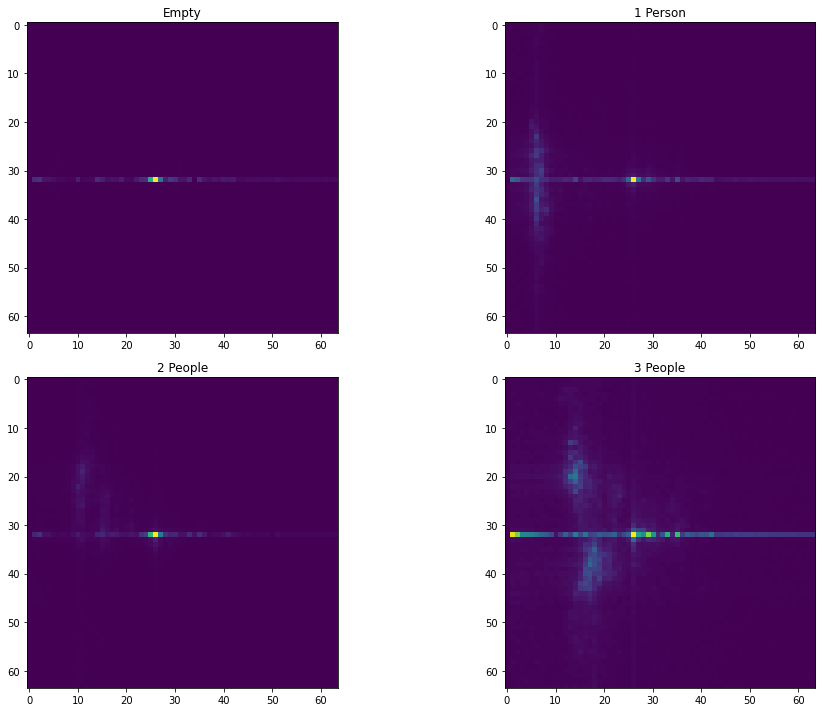

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
random_sample = np.random.randint(0, data_empty_reshaped.shape[0])
data_arr = [data]
axs[0, 0].imshow(data_empty_reshaped[random_sample,:, :, 1])
axs[0,0].set_title("Empty")
axs[0, 1].imshow(data_1p_reshaped[random_sample,:, :, 1])
axs[0,1].set_title("1 Person")
axs[1, 0].imshow(data_2p_reshaped[random_sample,:, :, 1])
axs[1,0].set_title("2 People")
axs[1, 1].imshow(data_3p_reshaped[random_sample,:, :, 1])
axs[1,1].set_title("3 People")
fig.tight_layout()

    We obtain a very thick line where the velocity is 0. This is the 32th line. The data on this line corresponds to all static objects observed by the radar. We should filter out this line to see the moving object more clearly.

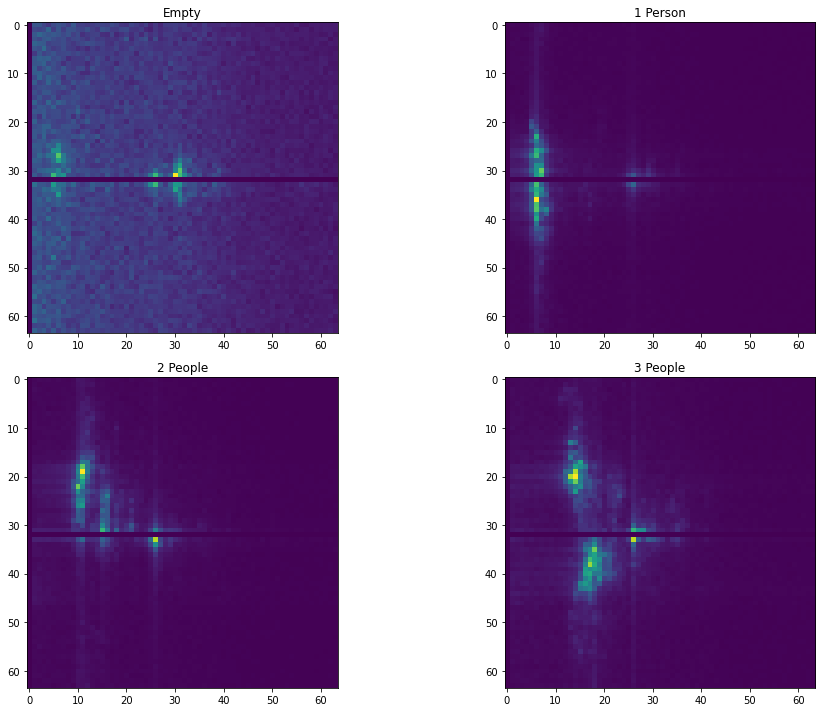

In [15]:
data_empty_reshaped[:,32,:,:] = 0
data_1p_reshaped[:,32,:,:] = 0
data_2p_reshaped[:,32,:,:] = 0
data_3p_reshaped[:,32,:,:] = 0
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
pos = axs[0, 0].imshow(data_empty_reshaped[random_sample,:, :, 1])
fig.colorbar(pos, ax=axs[0, 0])
axs[0,0].set_title("Empty")
axs[0, 1].imshow(data_1p_reshaped[random_sample,:, :, 1])
axs[0,1].set_title("1 Person")
axs[1, 0].imshow(data_2p_reshaped[random_sample,:, :, 1])
axs[1,0].set_title("2 People")
axs[1, 1].imshow(data_3p_reshaped[random_sample,:, :, 1])
axs[1,1].set_title("3 People")
fig.tight_layout()

    We can already see clearly moving objects in the image. 

#### Different data preprocesing techniques